In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from useful_functions import *
import seaborn as sns

In [3]:
df = pd.read_csv('../data/220316_ghost_nrt_filtered.tsv', sep='\t')
design_matrix = pd.read_csv('../data/design_matrix_group_de_early_time_points_subtypes.tsv', sep='\t')

GroupOneCols = design_matrix[design_matrix['Group'] == 1]['Sample'].values
GroupTwoCols = design_matrix[design_matrix['Group'] == 2]['Sample'].values


# logarithmize all intensity values from start?
# Impute values (DPKS for uniform imputation)

### Peptide distribution in samples

# unique proteins: 1039 


<Figure size 432x288 with 0 Axes>

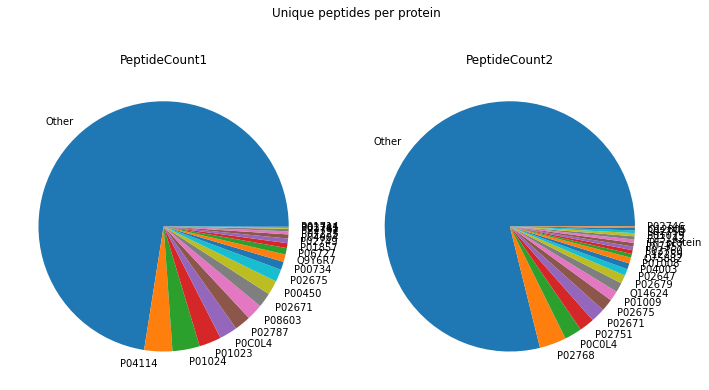

In [20]:
nr_unique_proteins = len(df['Protein'].unique())
print(f'# unique proteins: {nr_unique_proteins} ')

df['PeptideCount1'] = df[GroupOneCols].count(axis=1)
df['PeptideCount2'] = df[GroupTwoCols].count(axis=1)
df['IntensitySum1'] = df[GroupOneCols].sum(axis=1)
df['IntensitySum2'] = df[GroupTwoCols].sum(axis=1)
df['IntensityMean1'] = df[GroupOneCols].mean(axis=1)
df['IntensityMean2'] = df[GroupTwoCols].mean(axis=1)
df['FC'] = df['IntensityMean1'] / df['IntensityMean2']
df['IntensitySum'] = df['IntensitySum1'] + df['IntensitySum2']

def savefig(figureFileName):
    plt.tight_layout()
    plt.savefig(f'../plots/{figureFileName}.jpg', dpi=300, bbox_inches='tight')

def plot_peptides_per_protein_piechart(df):
    plt.clf()
    nr_proteins = 25
    def make_other_label(row, top_x_proteins):
        if row['Protein'] in top_x_proteins:
               return row['Protein']
        else:
            return 'Other'
    fig, axs = plt.subplots(1,2, figsize=(10,6))
    for ax, PeptideCount in zip(axs.ravel(), ['PeptideCount1','PeptideCount2']):
        df.sort_values(PeptideCount, ascending=False, inplace=True)
        top_x_proteins = df['Protein'][0:nr_proteins].values
        df['labels'] = df.apply(lambda x: make_other_label(x, top_x_proteins), axis=1)
        df_grouped = df.groupby('labels', as_index=False).sum()
        df_grouped.sort_values(PeptideCount, ascending=False, inplace=True)
        ax.pie(x=df_grouped[PeptideCount].values[0:nr_proteins], labels=df_grouped['labels'].values[0:nr_proteins])
        ax.set_title(PeptideCount)
    plt.suptitle('Unique peptides per protein')
    savefig('Protein_pie')
    
plot_peptides_per_protein_piechart(df)


<Figure size 432x288 with 0 Axes>

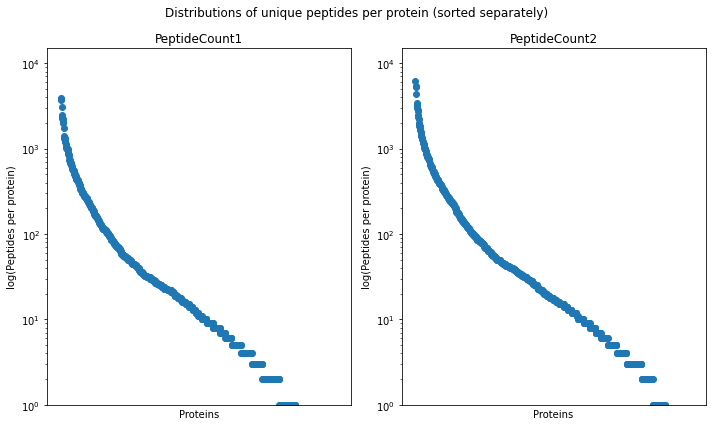

In [21]:
def plot_peptide_distribution(df):
    plt.clf()
    fig, axs = plt.subplots(1,2, figsize=(10,6))
    df = df.groupby('Protein', as_index=False).sum()
    

    
    for ax, PeptideCount in zip(axs.ravel(), ['PeptideCount1','PeptideCount2']):
        df.sort_values(PeptideCount, ascending=False, inplace=True)
        ax.scatter(x=range(len(df['Protein'])), y=df[PeptideCount].values)
        ax.tick_params(
            axis='x',         
            which='both',     
            bottom=False,      
            top=False,        
            labelbottom=False) 
        ax.set_yscale('log')
        ax.set_ylim([1, 1.5*10**4])
        ax.set_ylabel('log(Peptides per protein)')
        ax.set_xlabel('Proteins')
        ax.set_title(PeptideCount)
    plt.suptitle('Distributions of unique peptides per protein (sorted separately)')
    savefig('ProteinDistribution')
plot_peptide_distribution(df)

/tmp/ipykernel_3108/3753872381.py:3: RuntimeWarning: divide by zero encountered in log
  log_sum_I = [np.log(x) for x in df.groupby('Protein').sum()['IntensitySum'].values]


Text(0, 0.5, 'log10(MEAN(FC))')

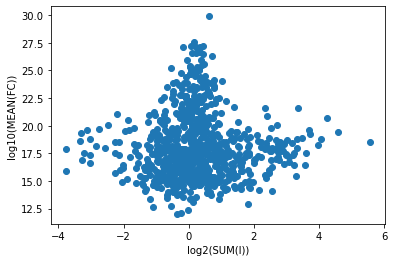

In [30]:
plt.clf()
mean_FC = [np.log2(x) for x in df.groupby('Protein').mean()['FC'].values]
log_sum_I = [np.log(x) for x in df.groupby('Protein').sum()['IntensitySum'].values]
plt.scatter(x=mean_FC,y=log_sum_I)
plt.xlabel('log2(SUM(I))')
plt.ylabel('log10(MEAN(FC))')


### Differential expression
Peptide Level:

In [32]:
df['pvalue'] = df.apply(lambda x: get_p_value(x, GroupOneCols, GroupTwoCols), axis=1)
df

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=

,PeptideSequence,Charge,Decoy,Protein,RetentionTime,PeptideQValue,ProteinQValue,TM_M2012_010,TM_M2012_011,TM_M2012_012,...,PeptideCount2,IntensitySum1,IntensitySum2,IntensityMean1,IntensityMean2,labels,pvalue,fold,FC,IntensitySum
1885,NPSSAGSWNSGSSGPGSTGNR,2,0,P02671,1770.05,0.000000,0.0,76500800.0,602759000.0,210512000.0,...,42,3.217329e+09,4.137797e+09,1.072443e+08,9.851898e+07,P02671,0.688968,1.088565,1.088565,7.355126e+09
12064,AFIQLWAFDAVK,2,0,P02760,5119.45,0.000000,0.0,46793500.0,33136500.0,35234300.0,...,42,8.894790e+08,1.022014e+09,2.964930e+07,2.433368e+07,P02760,0.215445,1.218447,1.218447,1.911493e+09
11903,SHC(UniMod:4)IAEVENDEMPADLPSLAADFVESK,4,0,P02768,5003.13,0.000000,0.0,2352180.0,950344.0,975019.0,...,42,6.643269e+08,2.396662e+09,2.214423e+07,5.706339e+07,P02768,0.059096,0.388064,0.388064,3.060989e+09
12296,VGLSGM(UniMod:35)AIADVTLLSGFHALR,3,0,P0C0L4,5250.62,0.000000,0.0,20277800.0,47709000.0,39647300.0,...,42,4.874137e+08,4.587891e+08,1.624712e+07,1.092355e+07,P0C0L4,0.061685,1.487348,1.487348,9.462028e+08
2743,KWQEEM(UniMod:35)ELYR,3,0,P02647,2088.24,0.000000,0.0,147067000.0,15475400.0,12072900.0,...,42,2.068686e+09,1.774842e+09,6.895620e+07,4.225815e+07,P02647,0.329222,1.631784,1.631784,3.843528e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12448,DINQEVYNFLATAGAK,2,0,Q99798,5335.25,0.000000,0.0,NaN,NaN,NaN,...,0,0.000000e+00,0.000000e+00,NaN,NaN,Other,NaN,NaN,NaN,0.000000e+00
12456,YTPEEIAMATVTALR,2,0,P09972,5340.90,0.001187,0.0,NaN,NaN,NaN,...,0,0.000000e+00,0.000000e+00,NaN,NaN,Other,NaN,NaN,NaN,0.000000e+00
12870,IADFELPTIIVPEQTIEIPSIK,4,0,P04114,5566.81,0.000000,0.0,NaN,NaN,NaN,...,0,0.000000e+00,0.000000e+00,NaN,NaN,Other,NaN,NaN,NaN,0.000000e+00
12758,YEETVFYGLQYILNK,2,0,P43490,5501.74,0.001498,0.0,NaN,NaN,NaN,...,0,0.000000e+00,0.000000e+00,NaN,NaN,Other,NaN,NaN,NaN,0.000000e+00


Text(0.5, 0, 'log2(Group 1 / Group 2)')

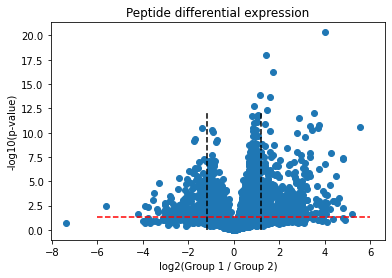

In [33]:
plt.scatter(x=[np.log2(x) for x in df['fold']] , y=[-np.log(val) for val in df['pvalue'].values])
plt.vlines(1.2, ymin=0, ymax=12, color='k', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=12,color='k', linestyle='dashed')
plt.hlines(1.31, xmin=-6, xmax=6, color='red', linestyle='dashed')
plt.title('Peptide differential expression')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Group 1 / Group 2)')

### Protein level

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3108/3924577808.py:9: RuntimeWarning: Mean of empty slice
  logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
/tmp/ipykernel_3108/3924577808.py:9: RuntimeWarning: Mean of empty slice
  logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages

Number of significantly differing proteins: 147


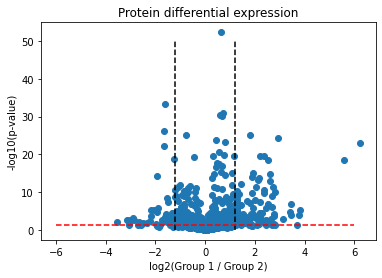

In [18]:

pvalues = []
proteins = []
logfold_changes = []
for protein in df['Protein'].unique():
    protein_df = df[df['Protein'] == protein]
    vals_group_1 = protein_df[GroupOneCols].values.flatten()
    vals_group_2 = protein_df[GroupTwoCols].values.flatten()
    statistic, pval = stats.ttest_ind(vals_group_1[~np.isnan(vals_group_1)], vals_group_2[~np.isnan(vals_group_2)])
    logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
    
    pvalues.append(pval)
    proteins.append(protein)
    logfold_changes.append(logfold_change)



log_pval = [-np.log(x) for x in pvalues]
dep = pd.DataFrame({'protein':proteins, 'pval': log_pval, 'FC':logfold_changes})

plt.scatter(x=logfold_changes,y=log_pval)

plt.vlines(1.2, ymin=0, ymax=50, color='k', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=50,color='k', linestyle='dashed')
plt.hlines(1.31, xmin=-6, xmax=6, color='red', linestyle='dashed')
plt.title('Protein differential expression')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Group 1 / Group 2)')

dep = dep[dep['pval'] >1.3]
dep = dep[(dep['FC'] < -1.2) | (dep['FC'] > 1.2)]
print(f"Number of significantly differing proteins: {len(dep.index)}")

<AxesSubplot:ylabel='Count'>

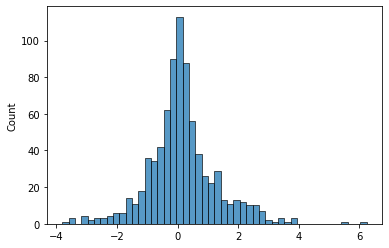

In [34]:
sns.histplot(logfold_changes)

## DPKS
---

In [14]:
from dpks.quant_matrix import QuantMatrix

quant_matrix = QuantMatrix(
    quantification_file="../data/220316_ghost_nrt_filtered.tsv",
    design_matrix_file="../data/design_matrix_group_de_early_time_points_subtypes.tsv"
)

# Need advice here
quantified_proteins = (
    quant_matrix
    .filter()
    .normalize(method="mean")
    .quantify(method="maxlfq")
    .impute(method="uniform", minvalue=1, maxvalue=2)
)

In [15]:
quant_df = quantified_proteins.to_df()
# is this correct?
quant_df['pvalue'] = quant_df.apply(lambda x: get_p_value(x, GroupOneCols, GroupTwoCols), axis=1)
quant_df['fold']= quant_df.apply(lambda x: get_difference(x, GroupOneCols, GroupTwoCols), axis=1)
quant_df

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=

,Protein,TM_M2012_010,TM_M2012_011,TM_M2012_012,TM_M2012_018,TM_M2012_019,TM_M2012_020,TM_M2012_028,TM_M2012_030,TM_M2012_031,...,TM_M2012_182,TM_M2012_183,TM_M2012_186,TM_M2012_188,TM_M2012_189,TM_M2012_196,TM_M2012_197,TM_M2012_198,pvalue,fold
0,P06396,21.660233,20.338497,20.539236,21.401932,21.117657,21.065078,21.401691,21.343707,21.247376,...,21.159304,21.093184,21.265361,20.836015,20.847019,22.799492,23.073422,23.082093,0.698722,0.059068
1,P10643,21.521370,20.855632,21.305960,21.534318,21.400979,21.439963,20.413134,20.310080,20.425679,...,21.236524,21.329424,21.471572,20.796613,21.297345,20.979003,21.198415,21.492553,0.590871,-0.078530
2,P03952,20.867693,20.927541,21.126907,21.390138,20.959282,20.817009,20.879257,20.571551,20.347904,...,20.520529,20.494745,21.023449,20.582302,20.695627,21.806561,22.089758,22.155970,0.004534,0.408387
3,P02750,22.881761,23.332485,23.818538,22.674727,23.182202,23.514962,22.361091,22.769435,23.106112,...,24.449461,24.524383,23.273757,22.642239,23.299472,23.585929,23.286014,23.433956,0.018238,-0.376649
4,Q04756,19.382387,19.085535,19.257750,20.011824,19.411222,19.207485,19.701001,19.354819,19.383568,...,18.648271,18.717076,19.370558,18.518855,19.125434,20.011903,20.131064,20.318493,0.000034,0.694073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,P01275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,P16104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.874353,NaN,NaN
1036,O00194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,Q6R327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,21.211152,NaN,NaN,0.343481,1.132804


Text(0.5, 0, 'log2(Group 1 / Group 2)')

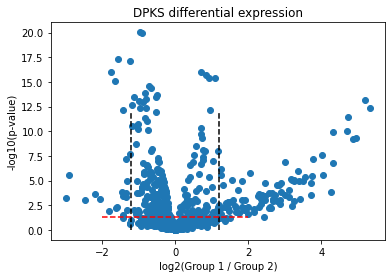

In [16]:
plt.scatter(x=quant_df['fold'],y=[-np.log(val) for val in quant_df['pvalue'].values])
plt.vlines(1.2, ymin=0, ymax=12, color='black', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=12,color='black', linestyle='dashed')
plt.hlines(1.31, xmin=-2, xmax=2, color='red', linestyle='dashed')
plt.title('DPKS differential expression')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Group 1 / Group 2)')

<AxesSubplot:ylabel='Count'>

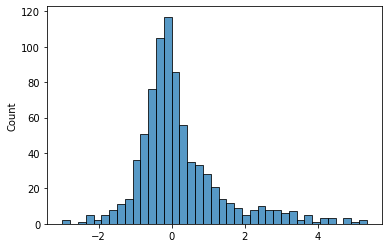

In [19]:
sns.histplot(quant_df['fold'].values)